# Introduction
I will be working on a dataset gotten from https://datasets.simula.no/depresjon/#download. The data was harvested from smart actigraph wrist watch belonging to 55 different individuals. This actigraph wristwatch takes patients health details such as patients motor activity, sleep/inactivity, heart rate, etc. In this case, the data contains the following columns:
- timestamp (one minute intervals)
- date (date of measurement)
- activity (activity measurement from the actigraph watch). 

The data set is already separated into two folders, both containing actigraph data (csv files) of patients collected over time. The first group is stored in a folder called "condition" which contains actigraph data of 23 depressed patients who suffer from either bipolar/unipolar while the second folder "control" contains actigraph data of 32 mormal people with no signs of depression.

There is another csv file containing the following columns; 
- number (patient identifier), 
- days (number of days of measurements), 
- gender (1 or 2 for female or male), 
- age (age in age groups), 
- afftype (1: bipolar II, 2: unipolar depressive, 3: bipolar I), 
- melanch (1: melancholia, 2: no melancholia), 
- inpatient (1: inpatient, 2: outpatient), 
- edu (education grouped in years), 
- marriage (1: married or cohabiting, 2: single), 
- work (1: working or studying, 2: unemployed/sick leave/pension), 
- madrs1 (MADRS score when measurement started), madrs2 (MADRS when measurement stopped). 

The essence of this work is to mix both data together and see if it will be possible to separate the mixed data back into their correct category using binary classification.

Let us begin.

### Import Necessary Libraries

In [115]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import random
from keras.preprocessing import sequence

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras import backend as K

# Data Preparation and cleaning

In [4]:
def get_data(folder, start = 0, stop = 1440, label = 1):
    """This function takes three arguments which are the folder to be fetched 
    from, the duration/number of minutes to observe. Default is 1440 
    as 1440 minutes make one day and then the label of the observation. 
    The main idea is to use a numpy array to map the activity levels to a category
    We are just saying... People who have their day like this (1440 minutes actigraph
    data -that is the features X) are depressed or ok (That is the label y 
    which can be 1 or 0 but 1 by default depending on the folder we are examining).)
    """
    
    # Construct the file path using the folder name
    folder = 'data/' + str(folder)
    FileNames = os.listdir(folder)
    
    # initialise lists which will contain an array of the activities of each patient and their label.
    X = []
    y = []

    # iterate through each file in the above file path
    for fileName in FileNames:
        
        # read each file
        df = pd.read_csv(folder + '/' + str(fileName))
        
        # get all unique dates 
        dates = df['date'].unique()
        
        # make a list container for activity levels
        activityLevelsPerDay = []
        
        # for each unique date
        for date in dates:
            
            # if the observations are up to one full day(1440 mins)
            if len(df[df['date']==date]) == 1440:
                
                # fetch only activity column
                temp = pd.DataFrame(df[df['date']==date]).drop(columns=['timestamp','date'])
                
                # store the activity column inside our list container
                activityLevelsPerDay.append(temp)
                
        # convert the activity levels into a numpy array suitable for machine learning.        
        for dailyActivityLevel in activityLevelsPerDay:
            activityVector = np.array(dailyActivityLevel["activity"], dtype='float32')
            
            # append this activity numpy array to the initial list and generate a 
            # corresponding label too.
            if len(activityVector) == 1440:
                X.append(activityVector[start : stop])
                y.append(np.array(label, dtype='float32'))
    
    # return the array
    return X, y


In [5]:
condition_data = get_data(folder='condition', label=1)
X_condition = condition_data[0]
y_condition = condition_data[1]

control_data = get_data(folder='control', label=0)
X_control = control_data[0]
y_control = control_data[1]

Let us look at the size of the data

In [6]:
print("Data of people with depressive condition are", len(X_condition), "rows \
while those of the normal people are", len(X_control), "rows.")

Data of people with depressive condition are 359 rows while those of the normal people are 670 rows.


# Data Visualisation


I will select a sample from the condition data and plot it.

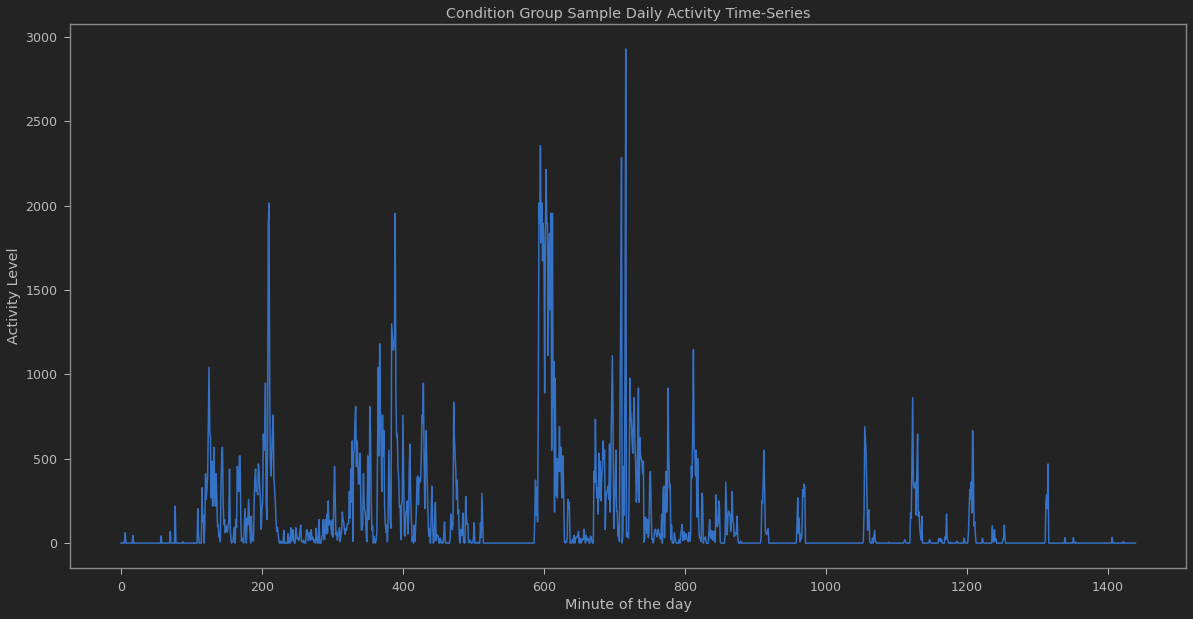

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(X_condition[0])
plt.title('Condition Group Sample Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)

# save image to include in 2nd Paper
plt.savefig('Condition Group Sample Daily Activity Time-Series.jpg') 
plt.show()

Also select a sample from the control data and plot it.

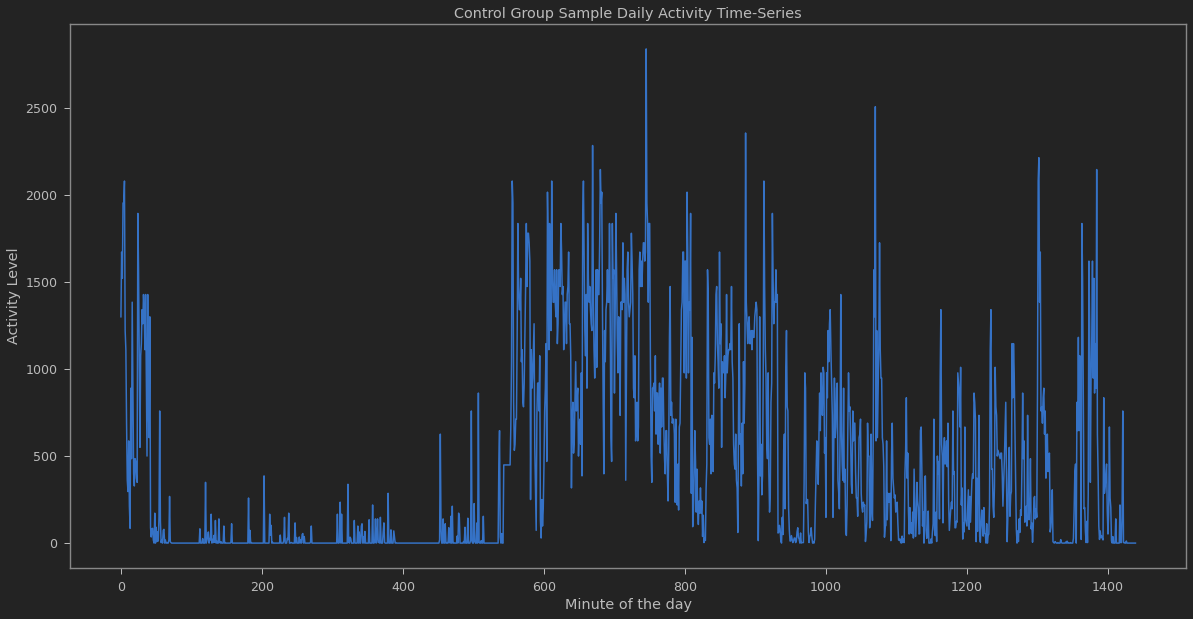

<Figure size 576x504 with 0 Axes>

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(X_control[0])
plt.title('Control Group Sample Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Control Group Sample Daily Activity Time-Series.png')

### Observation:
From my observation, at night (that is first half of the day, between 0 and 720 minutes) people with depression appear more active than normal people. Although this seems true using the visualisation from above, but the visualisation is only from one sample and it would be unfair to generalise. I am going to show more visualisations below to confirm my observation by getting the average sleep pattern of each class and ploting the same graph. Thereafter, I will plot both graphs on one plot for easier comparison.

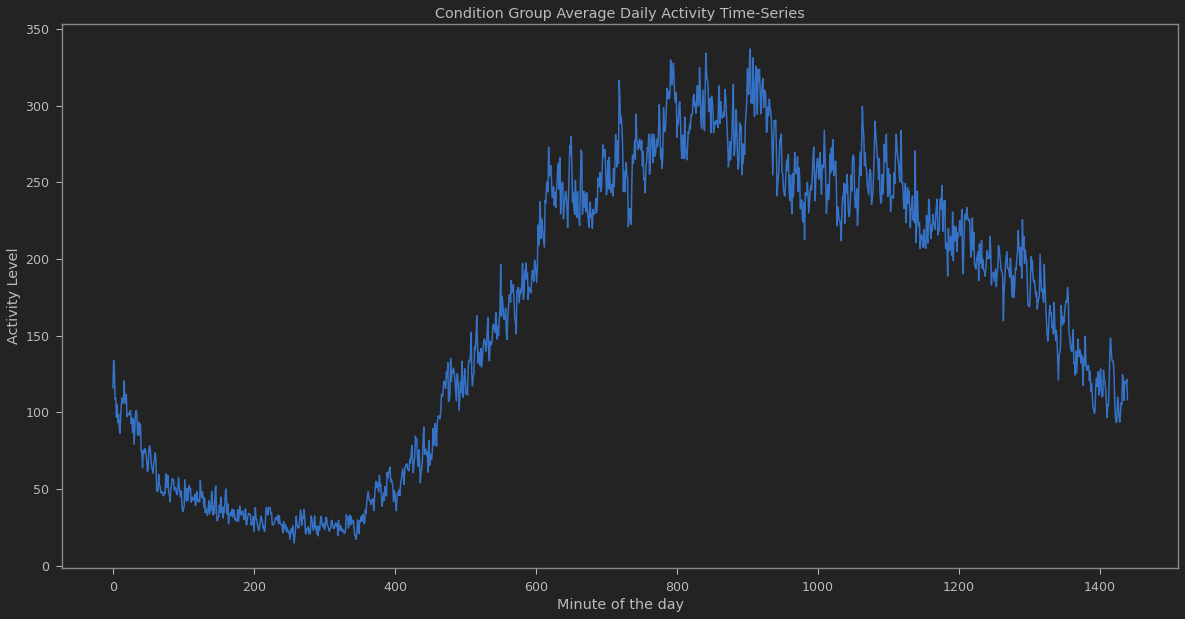

<Figure size 576x504 with 0 Axes>

In [9]:
# Get average for condition
condition_sum_vector = X_condition[0]
for x in range(1, len(X_condition)):
    condition_sum_vector += X_condition[x]
condition_avg_vector = condition_sum_vector / len(X_condition)

# plot
plt.figure(figsize=(20, 10))
plt.plot(condition_avg_vector)
plt.title('Condition Group Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Condition Group Average Daily Activity Time-Series.png')

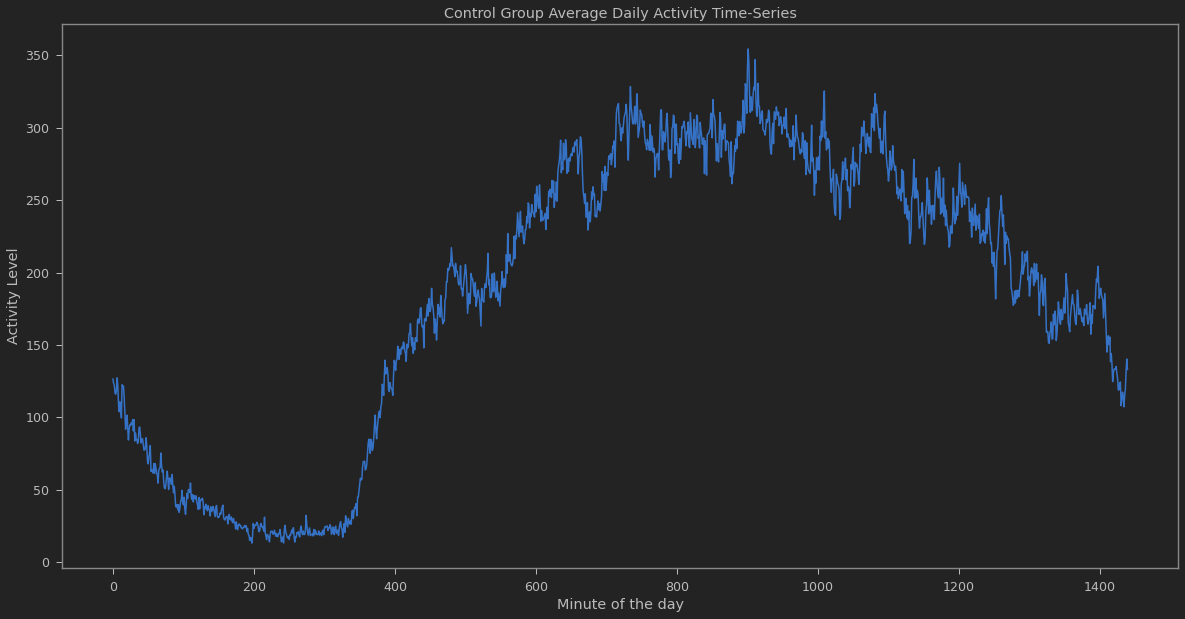

<Figure size 576x504 with 0 Axes>

In [10]:
# Get average for control
control_sum_vector = X_control[0]
for x in range(1, len(X_control)):
    control_sum_vector += X_control[x]
control_sum_vector = control_sum_vector / len(X_control)

# Plot
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector)
plt.title('Control Group Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Control Group Average Daily Activity Time-Series.png')

Now let us superimpose both graphs and compare.

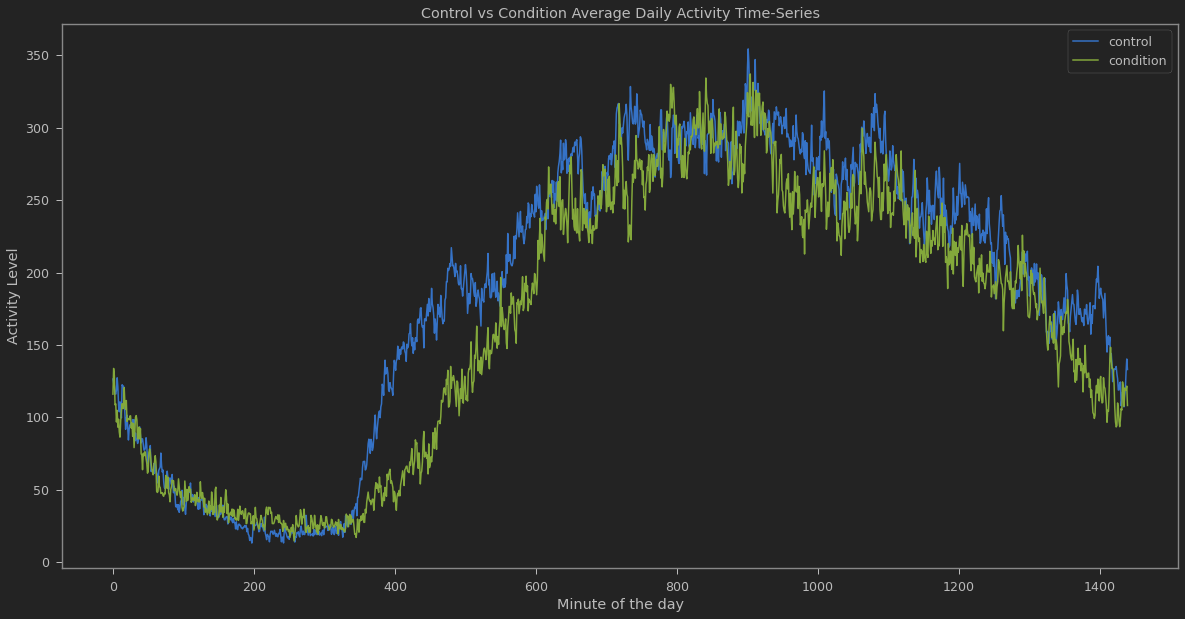

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector, label='control')
plt.plot(condition_avg_vector, label='condition')
plt.title('Control vs Condition Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.legend()
plt.grid(False)
plt.savefig('Control vs Condition Average Daily Activity Time-Series.png')
plt.show()

From the above, it is possible to separate the data in the first 720 minutes, precisely between 350 and 600 minutes which happens to be in the night. I will zoom in my visualisation below to further examine the data at night time, that is in the first half (720 minutes) of the day.

In [12]:
# get data for the first 720 minutes only.
# condition_night = get_data(folder='condition', stop=720)
# X_condition_night = condition_night[0]
# 
# control_night = get_data(folder='control', stop=720)
# X_control_night = control_night[0]

# get data for the first 720 minutes only.
condition_night = get_data(folder='condition', start=300, stop=600)
X_condition_night = condition_night[0]

control_night = get_data(folder='control', start=300, stop=600)
X_control_night = control_night[0]

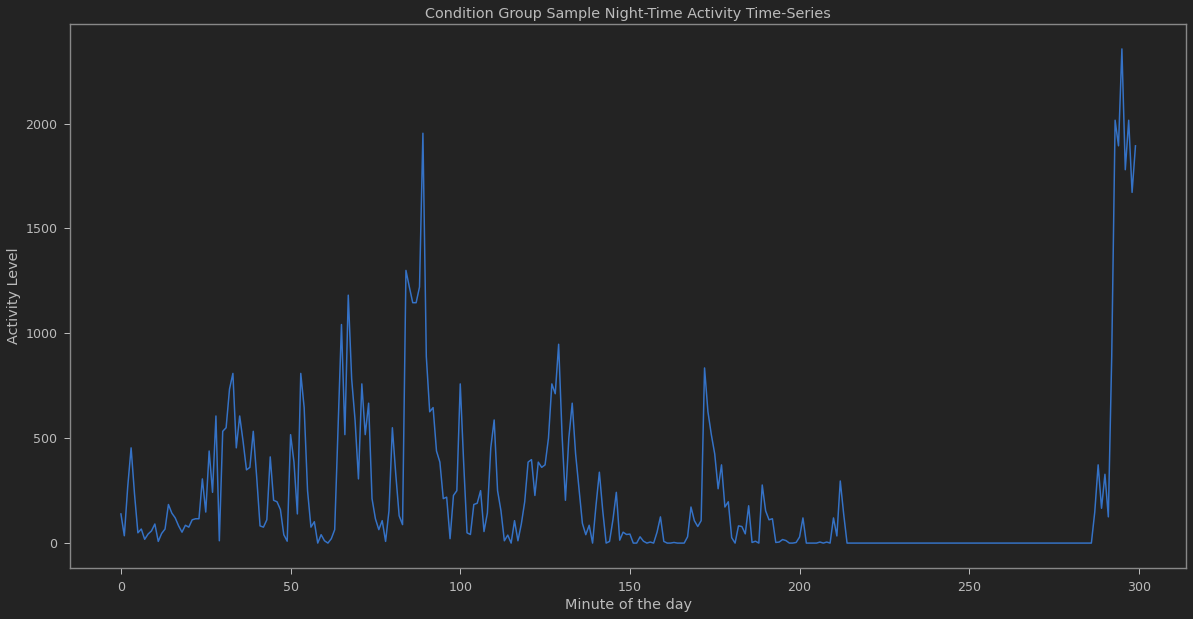

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(X_condition_night[0])
plt.title('Condition Group Sample Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.savefig('Condition Group Sample Night-Time Activity Time-Series.png')
plt.show()

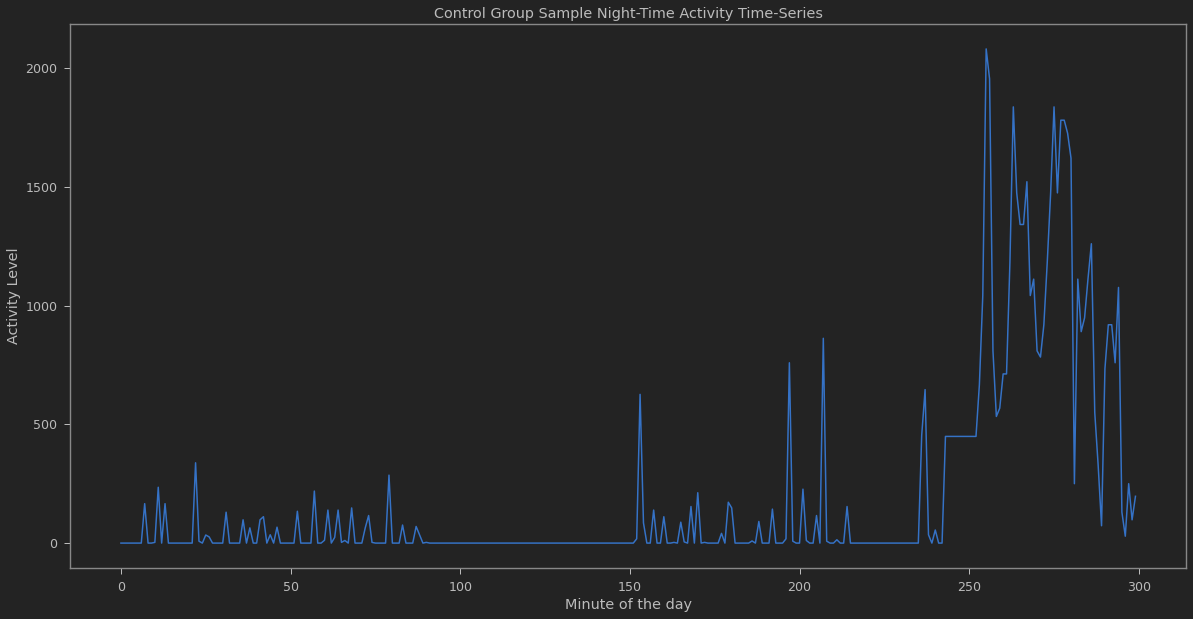

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(X_control_night[0])
plt.title('Control Group Sample Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.savefig('Control Group Sample Night-Time Activity Time-Series.png')
plt.show()

From the last two graphs above, viewing only the data at night time enables us to tell the difference more clearly. We will go ahead to find the average and plot again in like manner.

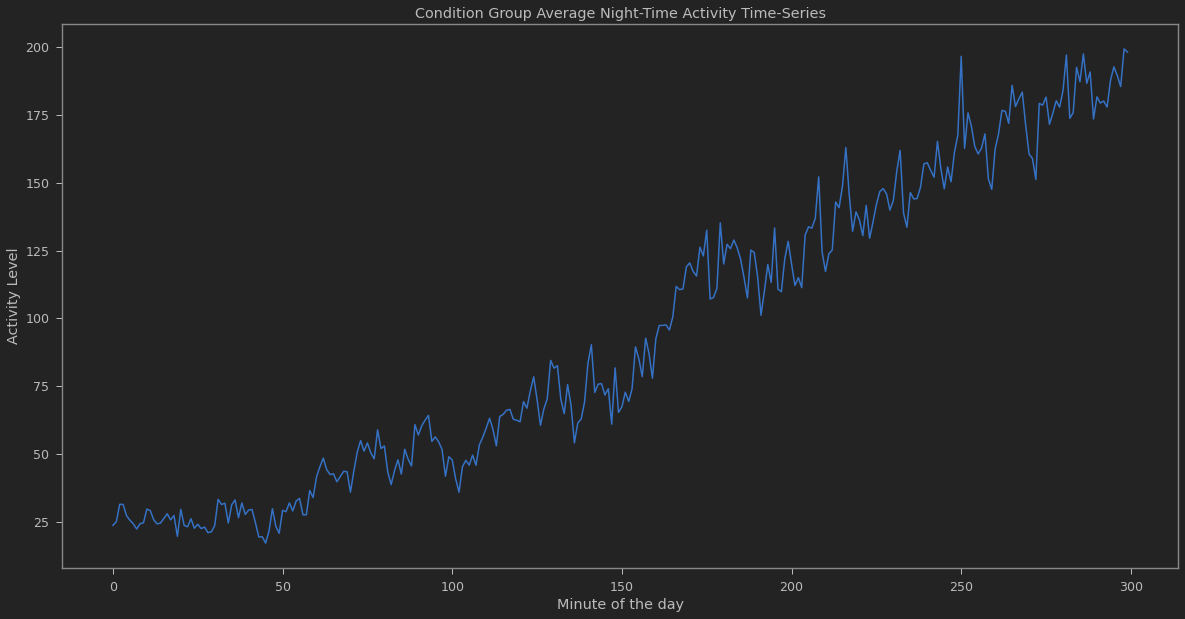

<Figure size 576x504 with 0 Axes>

In [15]:
condition_sum_vector = X_condition_night[0]
for x in range(1, len(X_condition_night)):
    condition_sum_vector += X_condition_night[x]
condition_avg_vector = condition_sum_vector / len(X_condition_night)

plt.figure(figsize=(20, 10))
plt.plot(condition_avg_vector)
plt.title('Condition Group Average Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Condition Group Average Night-Time Activity Time-Series.png')

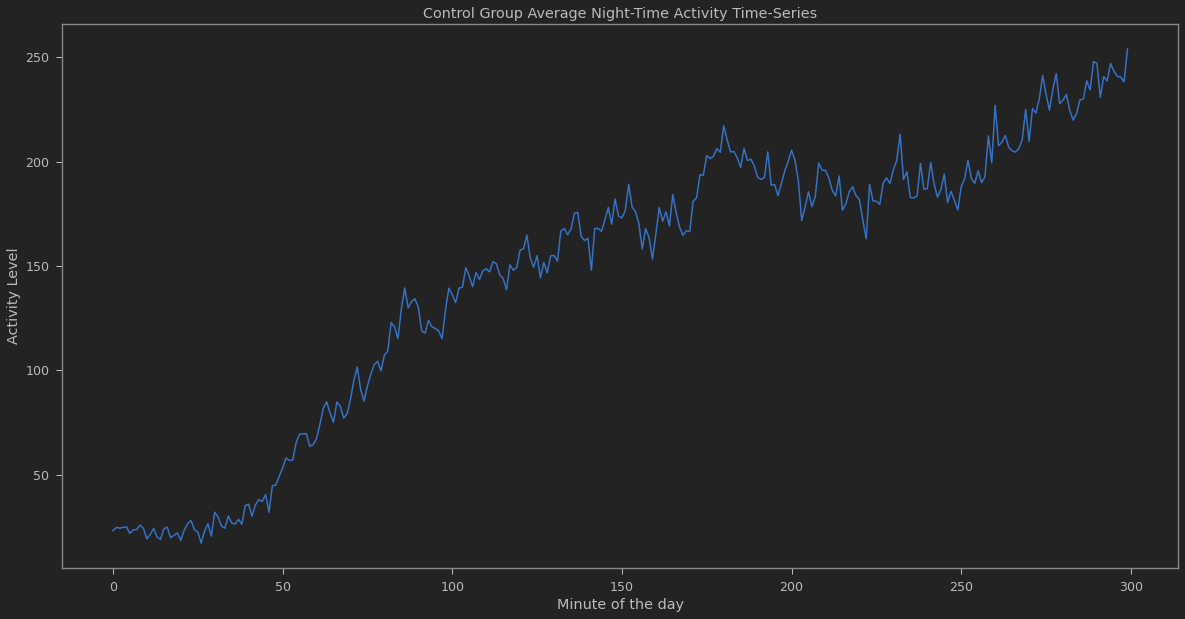

<Figure size 576x504 with 0 Axes>

In [16]:
control_sum_vector = X_control_night[0]
for x in range(1, len(X_control_night)):
    control_sum_vector += X_control_night[x]
control_sum_vector = control_sum_vector / len(X_control_night)

plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector)
plt.title('Control Group Average Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Control Group Average Night-Time Activity Time-Series.png')

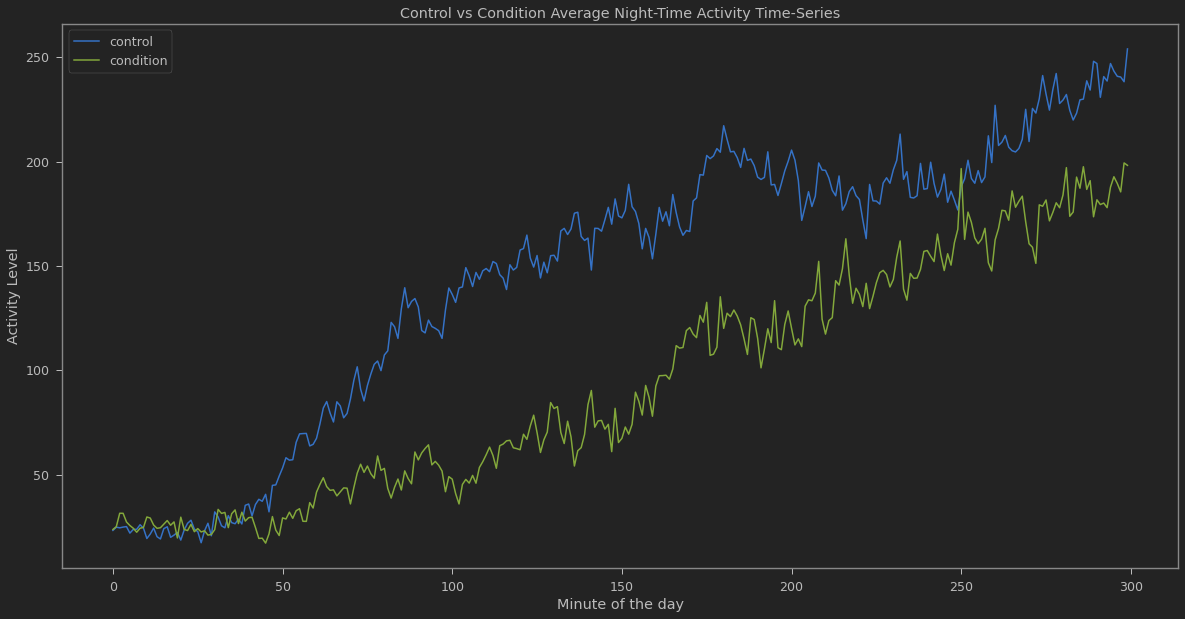

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector, label='control')
plt.plot(condition_avg_vector, label='condition')
plt.title('Control vs Condition Average Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.legend()
plt.grid(False)
plt.savefig('Control vs Condition Average Night-Time Activity Time-Series.png')
plt.show()

So working with data collected only between 300 and 600 minutes might do a better job in classifying our model correctly.

Now, let us combine our data and see if we can truly separate them.

In [18]:

condition = get_data(folder='condition', label=1)
X_condition = condition[0]
y_condition = condition[1]


control = get_data(folder='control', label=0)
X_control = control[0]
y_control = control[1]


X_condition.extend(X_control)
X = X_condition


y_condition.extend(y_control)
y = y_condition

In [19]:
print(len(X[0]))
print(len(y))

1440
1029


In [20]:
print(np.unique(y))

[0. 1.]


In [21]:
combinedDict = list(zip(X, y))
random.shuffle(combinedDict)
X[:], y[:] = zip(*combinedDict)

### combinedDict

In [22]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')
# X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [23]:
X

array([[338., 689., 517., ...,   0.,   0.,   0.],
       [179., 179., 179., ...,   0.,   0., 407.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  3.,   3.,   0., ...,   0.,   3.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [ 74.,  56.,  62., ..., 138.,  91.,  53.]], dtype=float32)

In [47]:
seed = 7
kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=seed)


In [38]:
print(np.unique(y))
print(len(X))

[0. 1.]
1029


I used the function bellow to perform a grid search when choosing the best C and gamma parameters for my SVM model

In [27]:
# ## C = [2**(1 + (n/100)) for n in range(-1025, 1025, 25)]
# C = np.arange(0.79, 0.82, 0.0001)
# bestC = {}
# i = 0
# l = len(C)
# accuracy = []
# for c in C:
#     i += 1
#     SupportVectorClassModel = SVC(kernel='rbf', C=c)
#     for train, test in kfold.split(X, y):
#         SupportVectorClassModel.fit(X[train], y[train])
#         y_pred = SupportVectorClassModel.predict(X[test])
#         acc = accuracy_score(y[test], y_pred)*100
#         accuracy.append(acc)
#         progress = str(round(((i * 100)/(l)), 1)) + "%"
#         
#     if i % 10 == 0:
#         print("Accuracy = %-20s C = %-20s progress = %-20s" % (acc, c, progress))
# 
#     if acc > 73:
#         bestC[acc] = c
#         cm = confusion_matrix(y[test], y_pred)
#         print("-----------------------------------Accuracy =", acc, "\nC =", c)
#         print(cm)
# 
# 
# 
# print("Maximum accuracy achieved is", max(bestC, key=int), "with c =", bestC[max(bestC, key=int)])
# print("Training samples:", len(X[train]), "\nwhile test samples:", len(X[test]))
# acc = round((sum(accuracy)/len(accuracy)), 4)
# print(acc)
# 

In [28]:
accuracy = []
SupportVectorClassModel = SVC(kernel='rbf', C=0.8)
for train, test in kfold.split(X, y):
    SupportVectorClassModel.fit(X[train], y[train])
    y_pred = SupportVectorClassModel.predict(X[test])
    acc = accuracy_score(y[test], y_pred)*100
    accuracy.append(acc)
    print("Accuracy = %-20s" % (acc))
    cm = confusion_matrix(y[test], y_pred)
    print(cm)
    print(classification_report(y[test], y_pred))


print("Training samples:", len(X[train]), "\nwhile test samples:", len(X[test]))
acc = round((sum(accuracy)/len(accuracy)), 4)
print("The average accuracy score after cross validation is", acc)

Accuracy = 78.84615384615384   
[[33  1]
 [10  8]]
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86        34
         1.0       0.89      0.44      0.59        18

    accuracy                           0.79        52
   macro avg       0.83      0.71      0.72        52
weighted avg       0.81      0.79      0.77        52

Accuracy = 73.07692307692307   
[[29  5]
 [ 9  9]]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.81        34
         1.0       0.64      0.50      0.56        18

    accuracy                           0.73        52
   macro avg       0.70      0.68      0.68        52
weighted avg       0.72      0.73      0.72        52

Accuracy = 65.38461538461539   
[[28  6]
 [12  6]]
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76        34
         1.0       0.50      0.33      0.40        18

    accuracy                 

Now, I want to get a similar code which I can apply to other algorithms as well and with single averaged metrics values instead of having them for each individual cross validation.

Let us do that in the code below.

In [107]:
def get_metrics(y_true, y_pred):
    """This function returns a list of dictionaries containing the required evaluation metrics"""
    result = []
    label = [0, 1]
    # the label created above represents category 1 or 0 and is used to get evaluation metrics for
    # both classes individually. label 0 represents not_depressed, and 1 represents depressed.
    
    for pos_label in label:
        metrics = {}
        
        # get confusion matrix prediction values
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # fetch the matrics
        prec = precision_score(y_true, y_pred, pos_label=pos_label)
        rec = recall_score(y_true, y_pred, pos_label=pos_label)
        acc = accuracy_score(y_true, y_pred)
        spec = tn / (tn + fp)
        mcc = matthews_corrcoef(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, labels=None, pos_label=pos_label)
        
        # attach the metrics to dictionary
        metrics['prec'] = round(prec, 3)
        metrics['rec'] = round(rec, 3)
        metrics['acc'] = round(acc, 3)
        metrics['spec'] = round(spec, 3)
        metrics['mcc'] = round(mcc, 3)
        metrics['f1'] = round(f1, 3)
        
        # put the dictionary into a list.
        result.append(metrics)
        
    return result




def get_average(result, metric, n_splits, category=1):
    """ 'result' is a list of dictionary which stores metrics derived accross several cross validations. When cross 
    validation of n_splits happens, this function returns the average of a paticular 
    'metric' appearing in 'result'. Specifying category = 1 or 0 gets the average 
    matrix for a particular category (depressed or non depressed)"""
    
    sum = 0
    for i in range(n_splits):
        sum += result[i][category][str(metric)]
    return sum/(n_splits)


def cross_validation_(algorithm, n_splits = 10):
    """This function does kfold validation on a model/algorithm, trains it and returns the overall weighted average"""
    
    kfold = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    # kfold declaration
    
    metrics_container = []
    # create a container to put in the resulting metrics from each crossvalidation
    
    # cross validation happens
    for train, test in kfold.split(X, y):
        
        # train the model
        algorithm.fit(X[train], y[train])
        
        # predict
        y_pred = algorithm.predict(X[test])
        
        # get the metrics and put into the metrics_container
        metric = get_metrics(y[test], y_pred)
        metrics_container.append(metric)
        
        
    combine_metric = {}

    # fish out the average metrics of both classes 0 and 1 and get their averages too.
    depressed_prec = get_average(result=metrics_container, metric='prec', n_splits=n_splits, category=1)
    not_depressed_prec = get_average(result=metrics_container, metric='prec', n_splits=n_splits, category=0)
    weighted_prec = (depressed_prec + not_depressed_prec)/2 
    
    depressed_rec = get_average(result=metrics_container, metric='rec', n_splits=n_splits, category=1)
    not_depressed_rec = get_average(result=metrics_container, metric='rec', n_splits=n_splits, category=0)
    weighted_rec = (depressed_rec + not_depressed_rec)/2

    acc = get_average(result=metrics_container, metric='acc', n_splits=n_splits)
    
    
    mcc = get_average(result=metrics_container, metric='mcc', n_splits=n_splits)
    
    depressed_f1 = get_average(result=metrics_container, metric='f1', n_splits=n_splits, category=1)
    not_depressed_f1 = get_average(result=metrics_container, metric='f1', n_splits=n_splits, category=0)
    weighted_f1 = (depressed_f1 + not_depressed_f1)/2
    
    # compile them into dictionaries
    not_depressed = {'prec': round(not_depressed_prec, 3), 'rec': round(not_depressed_rec, 3), 
                     'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(not_depressed_f1, 3)}
    depressed = {'prec': round(depressed_prec, 3), 'rec': round(depressed_rec, 3), 
                 'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(depressed_f1, 3)}
    mean = {'prec': round(weighted_prec, 3), 'rec': round(weighted_rec, 3), 
            'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(weighted_f1, 3)}
    
    # put the dictionary into another dictionary
    combine_metric['depressed'] = depressed
    combine_metric['not_depressed'] = not_depressed
    combine_metric['mean'] = mean
    
    #print output as dataframe to display the results neatly
    print(pd.DataFrame(combine_metric).T)
    
    print("============================================================================")
    cm = confusion_matrix(y[test], y_pred)
    print(cm)
#    print(classification_report(y[test], y_pred))


# Support Vector Model (kernel = 'rbf')

In [108]:
SupportVectorClassModel = SVC(kernel='rbf', C=0.8)
cross_validation_(SupportVectorClassModel)

                prec    rec    acc    mcc     f1
depressed      0.660  0.510  0.735  0.394  0.572
not_depressed  0.765  0.855  0.735  0.394  0.807
mean           0.713  0.682  0.735  0.394  0.690
[[61  6]
 [18 17]]


### Do not run the next code. it was only used for Grid Search in order to find the best parameters. It is computationally expensive  and takes time.

In [117]:
# # tune parameters
# # List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# 
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# 
# #Create new KNN object
# knn = KNeighborsClassifier()
# 
# #Use GridSearch
# clf = GridSearchCV(knn, hyperparameters, cv=10)
# 
# #Fit the model
# best_model = clf.fit(X, y)
# 
# # Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

# # Output:
# # Best leaf_size: 1
# # Best p: 2
# # Best n_neighbors: 4

Best leaf_size: 1
Best p: 2
Best n_neighbors: 4


In [121]:
neigh = KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=2)
cross_validation_(neigh)

                prec    rec    acc    mcc     f1
depressed      0.587  0.586  0.712  0.365  0.583
not_depressed  0.780  0.779  0.712  0.365  0.778
mean           0.684  0.682  0.712  0.365  0.681
[[52 15]
 [ 9 26]]


In [118]:
neigh = KNeighborsClassifier(n_neighbors=10)
cross_validation_(neigh)

                prec    rec    acc    mcc     f1
depressed      0.556  0.627  0.697  0.353  0.586
not_depressed  0.790  0.734  0.697  0.353  0.759
mean           0.673  0.680  0.697  0.353  0.672
[[53 14]
 [10 25]]


In [30]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
data = array([n for n in range(100)])
# prepare cross validation
kfold = KFold(8, True, 1)
# enumerate splits
for train, test in kfold.split(data):
    print('train: %s, test: %s' % (len(data[train]), len(data[test])))

train: 87, test: 13
train: 87, test: 13
train: 87, test: 13
train: 87, test: 13
train: 88, test: 12
train: 88, test: 12
train: 88, test: 12
train: 88, test: 12


/home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [31]:
for train, test in kfold.split(X, y):
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, 300), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', recall_m, precision_m, f1_m])
    
    model.fit(X[train], y[train], epochs=10, batch_size=64, verbose=0)
    scores = model.evaluate(X[test], y[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]))
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]))
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]))
    print("\n")
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    f1_scores.append(scores[4])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

ValueError: in user code:

    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/trazom/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1440]


In [ ]:
accuracy_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

In [ ]:
for train, test in kfold.split(X, y):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, input_shape=(1, 300))))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', recall_m, precision_m, f1_m])
    
#print(X[train].dtype)
#print(y[train].dtype)

    model.fit(X[train], y[train], epochs=10, batch_size=64, verbose=0)
    scores = model.evaluate(X[test], y[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]))
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]))
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]))
    print("\n")
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    f1_scores.append(scores[4])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))